# Data Similarity
Previous experiments have had some strange results, with models occasionally performing abnormally well (or badly) on the out of sample set. To make sure that there are no duplicate samples or abnormally similar studies, I made this notebook

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from plotnine import *
from sklearn.metrics.pairwise import euclidean_distances

from saged import utils, datasets, models

## Load the data

In [2]:
dataset_config_file = '../../dataset_configs/refinebio_labeled_dataset.yml'
label = 'tb'
negative_class = 'healthy'
batch_correction_method = 'limma'

In [3]:
dataset_config_str = """name: "RefineBioMixedDataset"
compendium_path: "../../data/subset_compendium.pkl"
metadata_path: "../../data/aggregated_metadata.json"
label_path: "../../data/sample_classifications.pkl"
"""
dataset_config = yaml.safe_load(dataset_config_str)

dataset_name = dataset_config.pop('name')                                   
MixedDatasetClass = datasets.RefineBioMixedDataset                                

all_data = MixedDatasetClass.from_config(**dataset_config)                  
labeled_data = all_data.get_labeled()                                       
labeled_data.subset_samples_to_labels([label, negative_class])              
unlabeled_data = all_data.get_unlabeled()                                   

In [4]:
metadata_path = '../../data/aggregated_metadata.json'
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)

In [5]:
# Load binary data subsets the data to two classes. Update the label encoder to treat this
# data as binary so the F1 score doesn't break
labeled_data.recode()
label_encoder = labeled_data.get_label_encoder()

# Correct for batch effects
if batch_correction_method is not None:
    all_data = datasets.correct_batch_effects(all_data, batch_correction_method)
    labeled_data = all_data.get_labeled()
    labeled_data.subset_samples_to_labels([label, negative_class])
    unlabeled_data = all_data.get_unlabeled()

## Look for samples that are very similar to each other despite having different IDs

In [6]:
sample_names = all_data.get_samples()
assert len(sample_names) == len(set(sample_names))

sample_names[:5]

['E-MEXP-1635-04SE57HA300104',
 'E-MEXP-1635-04SE58HA300104',
 'E-MEXP-1635-04SE59HA300104',
 'E-MEXP-1635-04SE60HA300104',
 'E-MEXP-1635-04SE61HA300104']

In [10]:
expression = all_data.get_all_data()
print(len(sample_names))
print(expression.shape)

10234
(10234, 14634)


In [11]:
sample_distance_matrix = euclidean_distances(expression, expression)

# This is unrelated to debugging the data, I'm just curious
gene_distance_matrix = euclidean_distances(expression.T, expression.T)

In [12]:
sample_distance_matrix.shape

(10234, 10234)

In [13]:
sample_distance_matrix

array([[  0.        , 229.63496006, 191.61807908, ..., 291.17252304,
        391.23556671, 393.19107406],
       [229.63496006,   0.        , 205.46212241, ..., 272.1971383 ,
        384.90951054, 386.81184478],
       [191.61807908, 205.46212241,   0.        , ..., 288.72903712,
        373.24591396, 375.06196845],
       ...,
       [291.17252304, 272.1971383 , 288.72903712, ...,   0.        ,
        295.89958742, 300.01987743],
       [391.23556671, 384.90951054, 373.24591396, ..., 295.89958742,
          0.        ,  84.20189072],
       [393.19107406, 386.81184478, 375.06196845, ..., 300.01987743,
         84.20189072,   0.        ]])

In [14]:
# See if there are any zero distances outside the diagonal
num_zeros = 10234 * 10234 - np.count_nonzero(sample_distance_matrix)
num_zeros

10234

Since there are as many zeros as elements in the diagonal, there are no duplicate samples with different IDs (unless noise was added somewhere)

### Get all distances
Because we know there aren't any zeros outside of the diagonal, we can zero out the lower diagonal and use the the non-zero entries of the upper diagonal to visualize the distance distribution

In [15]:
triangle = np.triu(sample_distance_matrix, k=0)
triangle

array([[  0.        , 229.63496006, 191.61807908, ..., 291.17252304,
        391.23556671, 393.19107406],
       [  0.        ,   0.        , 205.46212241, ..., 272.1971383 ,
        384.90951054, 386.81184478],
       [  0.        ,   0.        ,   0.        , ..., 288.72903712,
        373.24591396, 375.06196845],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        295.89958742, 300.01987743],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  84.20189072],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [16]:
distances = triangle.flatten()
nonzero_distances = distances[distances != 0]
nonzero_distances.shape

(52362261,)

(array([9.0200000e+02, 1.5050000e+03, 5.1204900e+05, 7.2346100e+06,
        1.4635621e+07, 1.2535299e+07, 6.8178180e+06, 3.0295720e+06,
        1.2840650e+06, 6.0985900e+05, 2.7789800e+05, 2.3757600e+05,
        3.2737860e+06, 1.5276080e+06, 2.0169700e+05, 3.9350000e+04,
        3.1289000e+04, 8.6928000e+04, 2.4578000e+04, 2.5100000e+02]),
 array([7.93717650e-02, 6.84759416e+01, 1.36872511e+02, 2.05269081e+02,
        2.73665651e+02, 3.42062221e+02, 4.10458791e+02, 4.78855361e+02,
        5.47251930e+02, 6.15648500e+02, 6.84045070e+02, 7.52441640e+02,
        8.20838210e+02, 8.89234779e+02, 9.57631349e+02, 1.02602792e+03,
        1.09442449e+03, 1.16282106e+03, 1.23121763e+03, 1.29961420e+03,
        1.36801077e+03]),
 <BarContainer object of 20 artists>)

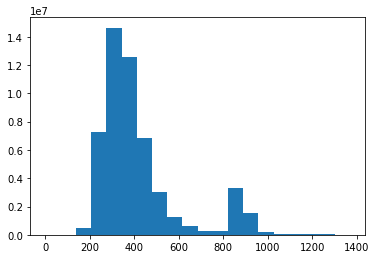

In [17]:
plt.hist(nonzero_distances, bins=20)

Distribution looks bimodal, probably due to different platforms having different distances from each other?

(array([3.72000e+02, 9.60000e+01, 3.13000e+02, 2.11000e+02, 3.19000e+02,
        2.49000e+02, 1.20300e+03, 9.97300e+03, 6.62850e+04, 2.87201e+05]),
 array([7.93717650e-02, 2.00714320e+01, 4.00634923e+01, 6.00555526e+01,
        8.00476129e+01, 1.00039673e+02, 1.20031733e+02, 1.40023794e+02,
        1.60015854e+02, 1.80007914e+02, 1.99999975e+02]),
 <BarContainer object of 10 artists>)

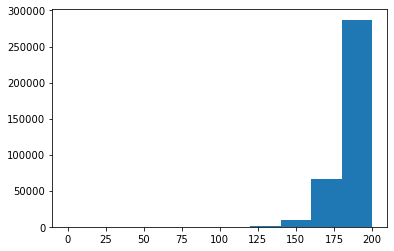

In [18]:
plt.hist(nonzero_distances[nonzero_distances < 200])

(array([  6., 365.,  72.,  25.,   8., 305., 125.,  86.,  94., 224.]),
 array([7.93717650e-02, 1.00591487e+01, 2.00389257e+01, 3.00187026e+01,
        3.99984796e+01, 4.99782565e+01, 5.99580334e+01, 6.99378104e+01,
        7.99175873e+01, 8.98973643e+01, 9.98771412e+01]),
 <BarContainer object of 10 artists>)

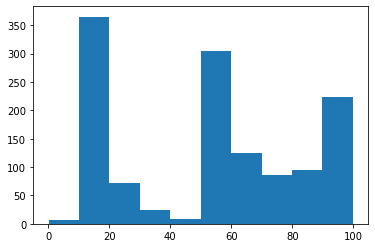

In [19]:
plt.hist(nonzero_distances[nonzero_distances < 100])

Looks like there may be some samples that are abnormally close to each other. I wonder whether they're in the same study

## Correspondence between distance and study

In [20]:
# There is almost certainly a vectorized way of doing this but oh well
distances = []
first_samples = []
second_samples = []
for row_index in range(sample_distance_matrix.shape[0]):
    for col_index in range(sample_distance_matrix.shape[0]):
        distance = sample_distance_matrix[row_index, col_index]
        if distance == 0:
            continue
        distances.append(distance)
        first_samples.append(sample_names[row_index])
        second_samples.append(sample_names[col_index])

In [21]:
distance_df = pd.DataFrame({'distance': distances, 'sample_1': first_samples,
                            'sample_2': second_samples})

In [22]:
# Free up memory to prevent swapping (probably hopeless if the user has < 32GB)
del(triangle)
del(sample_distance_matrix)
del(distances)
del(first_samples)
del(second_samples)
del(nonzero_distances)

In [23]:
distance_df

,distance,sample_1,sample_2
0,229.634960,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58HA300104
1,191.618079,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE59HA300104
2,206.978541,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE60HA300104
3,240.195692,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE61HA300104
4,271.821417,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE62HA300104
...,...,...,...
104724517,411.460941,SRR6870402,SRR6870397
104724518,407.601098,SRR6870402,SRR6870398
104724519,301.214339,SRR6870402,SRR6870399
104724520,300.019877,SRR6870402,SRR6870400


In [24]:
sample_to_study = all_data.sample_to_study

In [25]:
del(all_data)
del(labeled_data)
del(unlabeled_data)

In [26]:
distance_df['study_1'] = distance_df['sample_1'].map(sample_to_study)
distance_df['study_2'] = distance_df['sample_2'].map(sample_to_study)
distance_df['same_study'] = distance_df['study_1'] == distance_df['study_2']

In [27]:
distance_df.head()

,distance,sample_1,sample_2,study_1,study_2,same_study
0,229.634960,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58HA300104,E-MEXP-1635,E-MEXP-1635,True
1,191.618079,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE59HA300104,E-MEXP-1635,E-MEXP-1635,True
2,206.978541,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE60HA300104,E-MEXP-1635,E-MEXP-1635,True
3,240.195692,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE61HA300104,E-MEXP-1635,E-MEXP-1635,True
4,271.821417,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE62HA300104,E-MEXP-1635,E-MEXP-1635,True


In [28]:
print(len(distance_df))

104724522


For some reason my computer didn't want me to make a figure with 50 million points. We'll work with means instead

In [29]:
means_df = distance_df.groupby(['study_1', 'same_study']).mean()

In [30]:
means_df

distance
study_1     same_study            
E-MEXP-1635 False       346.965554
            True        271.840392
E-MEXP-3567 False       317.573726
            True        236.301581
GSE10474    False       390.363721
...                            ...
SRP131775   True        557.522400
SRP132709   False       408.568393
            True        398.432836
SRP136102   False       402.495573
            True        383.804467

[174 rows x 1 columns]

In [31]:
means_df = means_df.unstack(level='same_study')
means_df = means_df.reset_index()
means_df.head()

study_1    distance            
same_study                    False        True
0           E-MEXP-1635  346.965554  271.840392
1           E-MEXP-3567  317.573726  236.301581
2              GSE10474  390.363721  366.519368
3             GSE112811  350.365171  276.264297
4              GSE11755  481.884487  520.893960

In [32]:
# Get rid of the multilevel confusion
means_df.columns = means_df.columns.droplevel()

means_df.columns = ['study_name', 'distance_to_other', 'distance_to_same']
means_df['difference'] = means_df['distance_to_other'] - means_df['distance_to_same']
means_df.head()

,study_name,distance_to_other,distance_to_same,difference
0,E-MEXP-1635,346.965554,271.840392,75.125163
1,E-MEXP-3567,317.573726,236.301581,81.272145
2,GSE10474,390.363721,366.519368,23.844353
3,GSE112811,350.365171,276.264297,74.100874
4,GSE11755,481.884487,520.893960,-39.009473


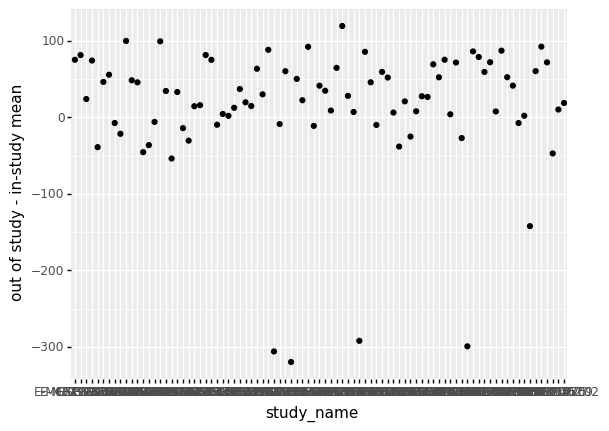

<ggplot: (8791901875637)>

In [37]:
plot = ggplot(means_df, aes(x='study_name', y='difference')) 
plot += geom_point()
plot += ylab('out of study - in-study mean')
plot

In [34]:
means_df.sort_values(by='difference')

,study_name,distance_to_other,distance_to_same,difference
38,GSE42834,877.009616,1196.615115,-319.605499
35,GSE40553,901.551269,1207.377101,-305.825832
69,GSE83456,891.123738,1190.250458,-299.126720
50,GSE58411,880.542332,1172.460873,-291.918541
80,SRP049820,602.853087,744.992813,-142.139726
...,...,...,...,...
41,GSE45923,336.665715,244.603096,92.062619
82,SRP077975,336.233798,243.975919,92.257879
15,GSE21592,329.633644,230.418254,99.215390
9,GSE14844,332.476449,232.749692,99.726757


These results indicate that most of the data is behaving as expected (the distance between pairs of samples from different studies is less than the distance between pairs of samples within the same study).

The outliers are mostly bead-chip, which makes sense (though they shouldn't be in the dataset and I'll need to look more closely at that later). The one exception is SRP049820 which is run on an Illumina Genome Analyzer II. Maybe it's due to the old tech?